In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def f(x):
    return 3*x**2 - 4*x + 5

In [3]:
f(2.2)

10.720000000000002

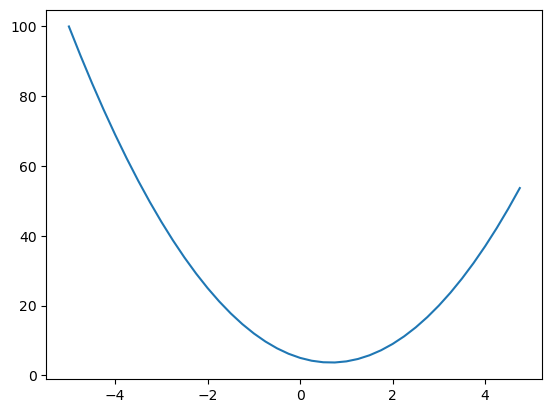

In [4]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [5]:
h = 0.00001
x = 0.67
(f(x+h) - f(x)) / h

0.020030000014159555

In [6]:
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [7]:
a = 2.0
b = -3.0
c = 10.0
h = 0.0001

d1 = a*b + c
c += h
d2 = a*b + c

print("d1", d1)
print("d2", d2)
print("slope", (d2 - d1)/h)

d1 4.0
d2 4.0001
slope 0.9999999999976694


In [325]:
class Value:
    
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data}, label={self.label})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += out.grad * 1.0
            other.grad += out.grad * 1.0
        out._backward = _backward
         
        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += out.grad * other.data
            other.grad += out.grad * self.data
        out._backward = _backward

        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now, i.e., can't raise Value() to Value()"
        out = Value(self.data**other, (self, ), f'**{other}')

        def _backward():
            self.grad = out.grad * (other * self.data**other-1)
        out._backward = _backward

        return out

    def __rmul__(self, other):
        return self * other

    def __truediv__(self, other):
        return self * other**-1
    
    def __neg__(self):
       return self * -1

    def __sub__(self, other):
        return self + (-other)

    def __radd__(self, other):
        return self + other

    def __rsub__(self, other):
        return other + (-self)

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        
        return out

    def exp(self):
        
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.grad * out.data
        out._backward = _backward
    
        return out


    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
            for child in v._prev:
                build_topo(child)
            topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()



In [74]:
a = Value(3.0)
b = Value(2.0)
a/b

Value(data=1.5, label=)

In [77]:
(a-b)

Value(data=1.0, label=)

In [35]:
#inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

#weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

#bais
b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1w1+x2w2"
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

In [42]:
topo = []
visited = set()
def build_topo(v):
  if v not in visited:
    visited.add(v)
    for child in v._prev:
      build_topo(child)
    topo.append(v)

build_topo(o)
topo

[Value(data=6.881373587019543, label=b),
 Value(data=2.0, label=x1),
 Value(data=-3.0, label=w1),
 Value(data=-6.0, label=x1*w1),
 Value(data=0.0, label=x2),
 Value(data=1.0, label=w2),
 Value(data=0.0, label=x2*w2),
 Value(data=-6.0, label=x1w1+x2w2),
 Value(data=0.8813735870195432, label=n),
 Value(data=0.7071067811865476, label=o)]

In [81]:
import random


random.uniform?

Signature: random.uniform(a, b)
Docstring: Get a random number in the range [a, b) or [a, b] depending on rounding.
File:      ~/miniforge3/envs/andrej_nn/lib/python3.11/random.py
Type:      method

In [1]:
class Neuron:
  
  def __init__(self, nin):
    self.w = [Value(random.uniform(-1, -1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1, 1))
  
  def __call__(self, x):
    act = sum((wi*xi for wi,xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out

  def parameters(self):
    return self.w + [self.b]


  
class Layer:
  
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs
  
  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]
    
class MLP:
  
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

In [96]:
x = [2.0, 3.0]
n = Neuron(2)
n(x)

Value(data=-0.9999845404595222, label=)

In [109]:
n = Layer(1, 3)
n(x)

[Value(data=-0.9940426127171624, label=),
 Value(data=-0.9012350752626774, label=),
 Value(data=-0.9797776532098674, label=)]

In [502]:
n = MLP(3, [4, 4, 1])

In [503]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0]
# ys = [Value(y) for y in ys]

In [504]:
[(ygt,yout) for ygt,yout in zip(ys, ypred)]

[(1.0, Value(data=-0.9998814096952667, label=)),
 (-1.0, Value(data=-0.9998811292815818, label=)),
 (-1.0, Value(data=-0.9998811320205787, label=)),
 (1.0, Value(data=-0.9998682135277, label=))]

In [505]:
for k in range(100):
  
  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((ygt - yout)**2 for ygt,yout in zip(ys, ypred))

  # backprop
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()

  # optim
  for p in n.parameters():
    p.data += -0.1 * p.grad

  print(k, loss.data)

0 7.989338403312805
1 7.988920081269112
2 7.988360443952603
3 7.987671397878559
4 7.986726299488819
5 7.985222262191428
6 7.982232008526754
7 7.972742202733883
8 7.157319878100713
9 7.9954335560526495
10 7.995495533424261
11 7.995555845994075
12 7.995614561112384
13 7.995671741044652
14 7.995727444927645
15 7.99578173069975
16 7.995834650218566
17 7.995886254850654
18 7.995936593705551
19 7.995985712114826
20 7.996033654545772
21 7.9960804625710615
22 7.9961261762658
23 7.99617083352596
24 7.996214470888933
25 7.996257122368143
26 7.996298821238205
27 7.99633959920696
28 7.996379486859694
29 7.996418513241063
30 7.996456704970785
31 7.9964940895761325
32 7.996530691922292
33 7.996566535626312
34 7.996601644989027
35 7.996636041934742
36 7.996669748396726
37 7.996702784553287
38 7.996735170654205
39 7.996766925947395
40 7.996798068285713
41 7.996828614648176
42 7.996858582600632
43 7.996887989055443
44 7.9969168484800175
45 7.996945177174479
46 7.996972988708992
47 7.997000297330864
48 

In [166]:
# loss = [(yout - ygt)**2 for ygt,yout in zip(ys, ypred)] # ygt - yout doesn't work because in the Value class self is not converted to Value() if it is not Value() and only other is converted to Value() if it isn't. therefore the operation float-Value() isn't supported. But Value()-float is supported because float gets converted to Value() because the "other" parameter catches it and converts it Value(). I think I have set my --verbose=True
# loss

[Value(data=3.994156331191746, label=),
 Value(data=2.1418393194102684e-06, label=),
 Value(data=2.1418393194102684e-06, label=),
 Value(data=3.993354042749724, label=)]

In [170]:
n.layers[0].neurons[0].w[0]

Value(data=-1.0, label=)

Init signature: Neuron(nin)
Docstring:      <no docstring>
Type:           type
Subclasses:     